In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from functions import scalar_gaussian, dirichlet, beta, mode_beta
import math
from scipy.stats import norm
from scipy.special import digamma
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [23]:
K = 2 # two Gaussian components
mu_bar1 = 3 # mean for mu1
mu_bar2 = 15 # mean for mu2
sigma_1 = 2 # variance of distribution for mu1
sigma_2 = 10 # variance of distribution for mu2
sigma_y1 = 1 # variance of observations y under model 1
sigma_y2 = 3 # variance of observations y under model 2
p = 0.3 # probability of generating data from model 1

N = 10000 # once the means have been generated, we generate this many observations
y = np.zeros(N)

j1 = 0 # index for measurements from distribution with mean mu1
j2 = 0 # index for measurements from distribution with mean mu2

y1 = np.zeros(N)
y2 = np.zeros(N)
model = np.zeros(N)
mean_value = np.zeros((N, 2))

for n in range(N):
    mu1 = np.sqrt(sigma_1)*np.random.randn() # generate random mean mu1 for each sample
    mu1 = mu1 + mu_bar1
    mu2 = np.sqrt(sigma_2)*np.random.randn() # generate random mean mu2 for each sample
    mu2 = mu2 + mu_bar2

    x = np.random.rand()
    if x <= p: #model 1
        mu = mu1
        j1 = j1+1
        y1[j1] = np.sqrt(sigma_y1)*np.random.randn()
        y1[j1] = y1[j1] + mu
        y[n] = y1[j1]
        model[n] = 1
    else: # model 2
        mu = mu2
        j2 = j2+1
        y2[j2] = np.sqrt(sigma_y2)*np.random.randn()
        y2[j2] = y2[j2] + mu
        y[n] = y2[j2]
        model[n] = 2
    mean_value[n, :] = np.array([mu1, mu2]) # saves the models generated for n-th observation
                                            # to compute resposibility later

error = 0
prob_estimated = np.zeros(N)
model_estimated = np.zeros(N)

for n in range(N): # computing the likelihood of belonging to model k = 1 for each realization
    value1 = scalar_gaussian(y[n], mean_value[n, 0], sigma_y1)
    value2 = scalar_gaussian(y[n], mean_value[n, 1], sigma_y2)
    prob_estimated[n] = (p*value1)/(p*value1 + (1-p)*value2) # probability of belonging to model 1

    if prob_estimated[n] >= 0.5:
        model_estimated[n] = 1
    else:
        model_estimated[n] = 2
    if model_estimated[n] != model[n]:
        error += 1

T = int(max(y)+2)
f = np.array([])

for t in np.arange(-T, T, 0.01):
    f1 = scalar_gaussian(t, mu_bar1, sigma_y1+sigma_1)
    f2 = scalar_gaussian(t, mu_bar2, sigma_y2+sigma_2)
    f = np.append(f, p*f1 + (1-p)*f2)

print("error in assigning correct model", (error/N)*100)
print("total samples plus number of samples from models 1 and 2", N, j1, j2)

error in assigning correct model 0.24
total samples plus number of samples from models 1 and 2 10000 3106 6894


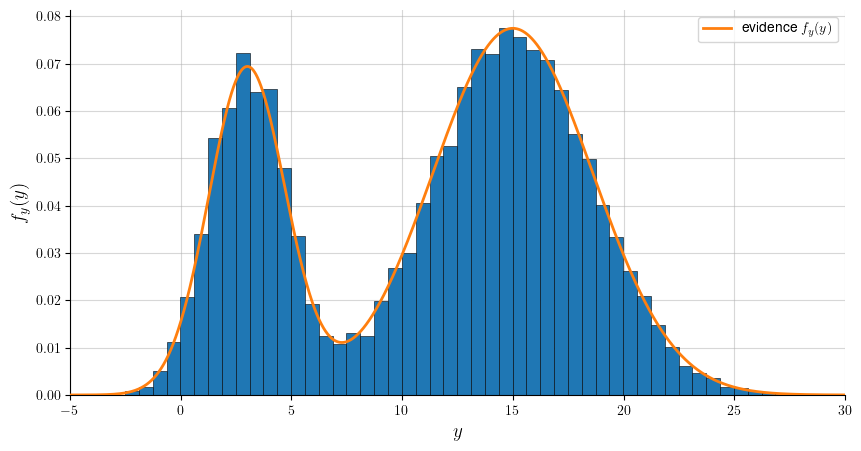

In [24]:
#figure 2 (evaluating evidence)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 5
fig = plt.figure()

ax = fig.add_subplot(111)
ax.hist(y, bins=50, density=True, zorder=2, edgecolor="black", linewidth=0.4)
ax.plot(np.arange(-T, T, 0.01), f, linewidth=2, label="evidence $f_y(y)$", zorder=3)
ax.set_xlabel("$y$", fontsize=14)
ax.set_ylabel("$f_y(y)$", fontsize=14)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim([-5, 30])
plt.grid(zorder=0, alpha=0.5)
plt.legend()

plt.savefig("figs/fig-2.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [25]:
K = 2 # two Gaussian components
mu_bar1 = 1 # mean for mu1
mu_bar2 = 8 # mean for mu2
sigma_1 = 2 # variance of distribution for mu1
sigma_2 = 5 # variance of distribution for mu2
sigma_y1 = 1 # variance of observations y under model 1
sigma_y2 = 4 # variance of observations y under model 2
p = 0.3 # probability of generating data from model 1

N = 1000 # Once the means have been generated, we generate this many observations
y = np.zeros(N)
y1 = np.zeros(N)
y2 = np.zeros(N)
model = np.zeros(N)

j1 = 0 # index for measurements from distribution with mean mu1
j2 = 0 # index for measurements frorm distribution with mean mu2

mu1 = mu_bar1 + np.sqrt(sigma_1)*np.random.randn() # generate one random mean mu1 for all N samples
mu2 = mu_bar2 + np.sqrt(sigma_2)*np.random.randn() # generate one random mean mu2 for all N samples

for n in range(N):
    x = np.random.rand()
    if x <= p: # model 1
        mu = mu1
        y1[j1] = np.sqrt(sigma_y1)*np.random.randn() + mu
        y[n] = y1[j1]
        model[n] = 1
        j1 += 1
    else: # model 2
        mu = mu2
        y2[j2] = np.sqrt(sigma_y2)*np.random.randn() + mu
        y[n] = y2[j2]
        model[n] = 2
        j2 += 1

mu_1_hat = np.random.randn()
mu_2_hat = np.random.randn()
sigma_1_hat = np.random.rand() + 0.00001
sigma_2_hat = np.random.rand() + 0.00001
epsilon = 0.000001

delta = 1
m = 0
M = 50 # maximum iterations

p_hat = np.random.rand(N)
p_hat_next = np.zeros(N)
KL_p = np.zeros(N)
L_next = np.zeros(N)
p_vec = np.zeros((N, M))
mu_1_vec = np.zeros(M)
mu_2_vec = np.zeros(M)
sigma_1_vec = np.zeros(M)
sigma_2_vec = np.zeros(M)

while delta >= epsilon and m < M:
    c1 = (mu_bar1 + mu_1_hat)**2 + sigma_1_hat
    c2 = (mu_bar2 + mu_2_hat)**2 + sigma_2_hat
    for n in range(N):
        y_obs = y[n]
        a = np.exp(((y_obs*(mu_bar1+mu_1_hat))/sigma_y1) - (1/(2*sigma_y1))*c1)
        b = np.exp(((y_obs*(mu_bar2+mu_2_hat))/sigma_y2) - (1/(2*sigma_y2))*c2)
        p_hat_next[n] = a/(a+b)
    
    mu_1_hat_next = np.squeeze(p_hat_next.reshape(-1, 1).T@(y-mu_bar1))/(sum(p_hat_next) + (sigma_y1/sigma_1))
    mu_2_hat_next = np.squeeze((sum(y-mu_bar2)-(p_hat_next.reshape(-1, 1).T@(y-mu_bar2))))/((N-sum(p_hat_next))+(sigma_y2/sigma_2))
    sigma_1_hat_next = sigma_y1/(sum(p_hat_next) + (sigma_y1/sigma_1))
    sigma_2_hat_next = sigma_y2/((N-sum(p_hat_next)) + (sigma_y2/sigma_2))

    KL_mu_1 = 0.5*((np.log(sigma_1_hat_next/sigma_1_hat)) - 1 + (sigma_1_hat/sigma_1_hat_next) + (mu_1_hat - mu_1_hat_next)**2/sigma_1_hat_next)
    KL_mu_2 = 0.5*((np.log(sigma_2_hat_next/sigma_2_hat)) - 1 + (sigma_2_hat/sigma_2_hat_next) + (mu_2_hat - mu_2_hat_next)**2/sigma_2_hat_next)

    for n in range(N):
        x = p_hat[n]
        s = p_hat_next[n]
        if x == 0:
            KL_p[n] = np.log(1/(1-s+0.0000000001)) # added a small number to avoid division by zero
        elif x == 1:
            KL_p[n] = np.log(1/(s+0.0000000001)) # added a small number to avoid division by zero
        else:
            KL_p[n] = ((1-x)*np.log((1-x)/(1-s+0.0000000001))) + x*np.log(x/(s+0.0000000001)) # added a small number to avoid division  by zero
        if math.isnan(KL_p[n]):
            print("")
    L_next[m] = (-KL_mu_1 - KL_mu_2 - sum(KL_p))
    if m > 0:
        delta = abs(L_next[m] - L_next[m-1])
    
    p_vec[:, m] = p_hat_next # saving evolution
    mu_1_vec[m] = mu_1_hat_next + mu_bar1
    mu_2_vec[m] = mu_2_hat_next + mu_bar2
    sigma_1_vec[m] = sigma_1_hat_next
    sigma_2_vec[m] = sigma_2_hat_next

    m += 1

    p_hat = p_hat_next
    mu_1_hat = mu_1_hat_next
    mu_2_hat = mu_2_hat_next
    sigma_1_hat = sigma_1_hat_next
    sigma_2_hat = sigma_2_hat_next

p_vec = p_vec[:, :m]
mu_1_vec = mu_1_vec[:m]
mu_2_vec = mu_2_vec[:m]
sigma_1_vec = sigma_1_vec[:m]
sigma_2_vec = sigma_2_vec[:m]
L_next = L_next[:m]

L = max(mu_1_vec.shape)

a1 = mu_1_vec[-1]-200*sigma_1_vec[-1]
a2 = mu_1_vec[-1]+200*sigma_1_vec[-1]
dd1 =(a2-a1)/1000
x1 = np.arange(a1, a2, dd1)
f1 = (1/np.sqrt(2*np.pi*sigma_1_vec[-1]))*np.exp((-0.5/sigma_1_vec[-1])*(x1 - mu_1_vec[-1])**2)

b1 = mu_2_vec[-1]-100*sigma_2_vec[-1]
b2 = mu_2_vec[-1]+100*sigma_2_vec[-1]
dd2 =(b2-b1)/1000
x2 = np.arange(b1, b2, dd2)
f2 = (1/np.sqrt(2*np.pi*sigma_2_vec[-1]))*np.exp((-0.5/sigma_2_vec[-1])*(x2 - mu_2_vec[-1])**2)

i = 0
T = int(max(y))+2
estimate_p = p_vec[:, -1].mean()
range_x = np.arange(-T, T, 0.01)
fy = np.zeros(range_x.shape)
for x in range_x:
    xx1 = scalar_gaussian(x, mu_1_vec[-1], sigma_y1)
    xx2 = scalar_gaussian(x, mu_2_vec[-1], sigma_y2)
    fy[i] = estimate_p*xx1 + (1-estimate_p)*xx2 
    i += 1

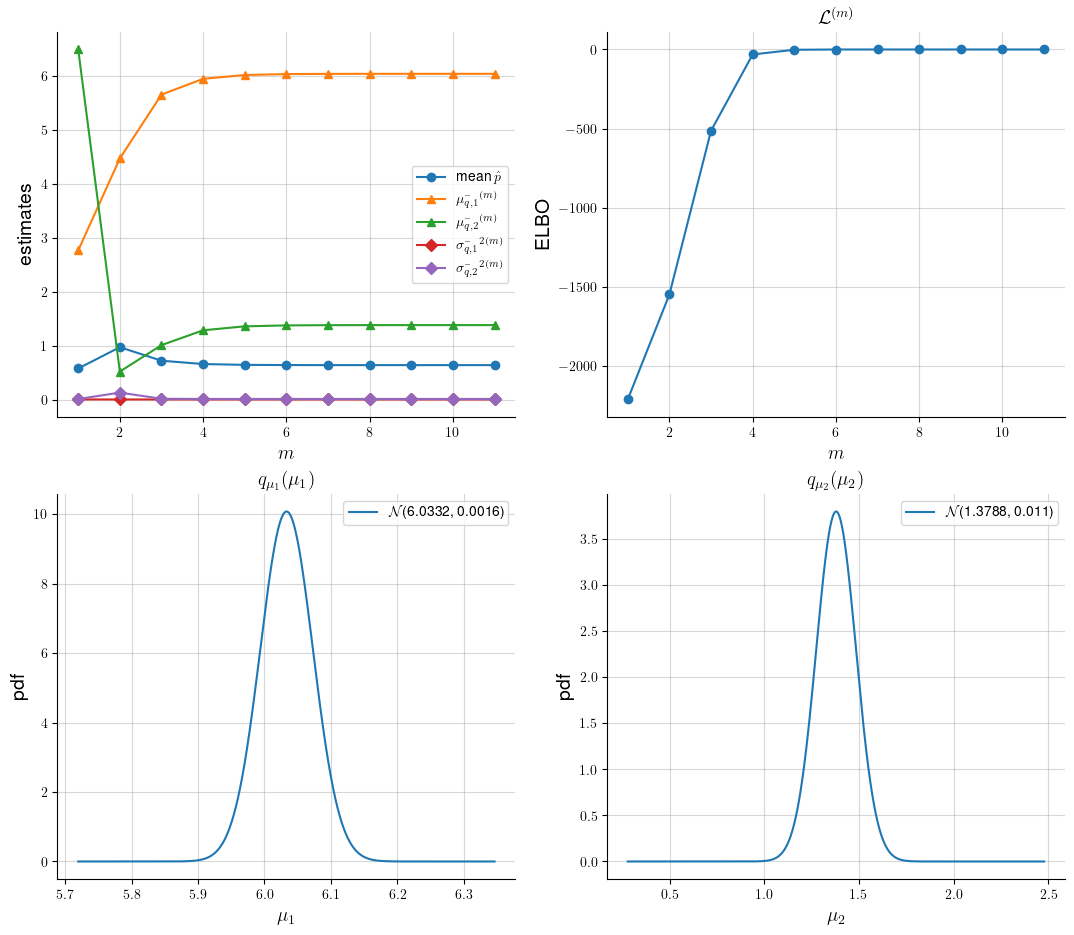

In [115]:
#figure 3 (estimates)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,11
fig = plt.figure()

ax = fig.add_subplot(221)

ax.plot(np.arange(1, L+1), p_vec.mean(axis=0), label="mean $\hat{p}$", marker="o")
ax.plot(np.arange(1, L+1), mu_1_vec, label="$\\bar{\mu_{q, 1}}^{(m)}$", marker="^")
ax.plot(np.arange(1, L+1), mu_2_vec, label="$\\bar{\mu_{q, 2}}^{(m)}$", marker="^")
ax.plot(np.arange(1, L+1), sigma_1_vec, label="$\\bar{\sigma_{q, 1}}^{2(m)}$", marker="D")
ax.plot(np.arange(1, L+1), sigma_2_vec, label="$\\bar{\sigma_{q, 2}}^{2(m)}$", marker="D")
ax.set_xlabel("$m$", fontsize=14)
ax.set_ylabel("estimates", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

ax = fig.add_subplot(222)

ax.plot(np.arange(1, L+1), L_next, marker="o")
ax.set_xlabel("$m$", fontsize=14)
ax.set_ylabel("ELBO", fontsize=14)
ax.set_title("${\cal L}^{(m)}$", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(223)

ax.plot(x1, f1, label="${\cal N}$"+f"({np.round(mu_1_vec[-1], 4)}, {np.round(sigma_1_vec[-1], 4)})")
ax.set_xlabel("$\mu_1$", fontsize=14)
ax.set_ylabel("pdf", fontsize=14)
ax.set_title("$q_{\mu_1}(\mu_1)$", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

ax = fig.add_subplot(224)

ax.plot(x2, f2, label="${\cal N}$"+f"({np.round(mu_2_vec[-1], 4)}, {np.round(sigma_2_vec[-1], 4)})")
ax.set_xlabel("$\mu_2$", fontsize=14)
ax.set_ylabel("pdf", fontsize=14)
ax.set_title("$q_{\mu_2}(\mu_2)$", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

plt.show()

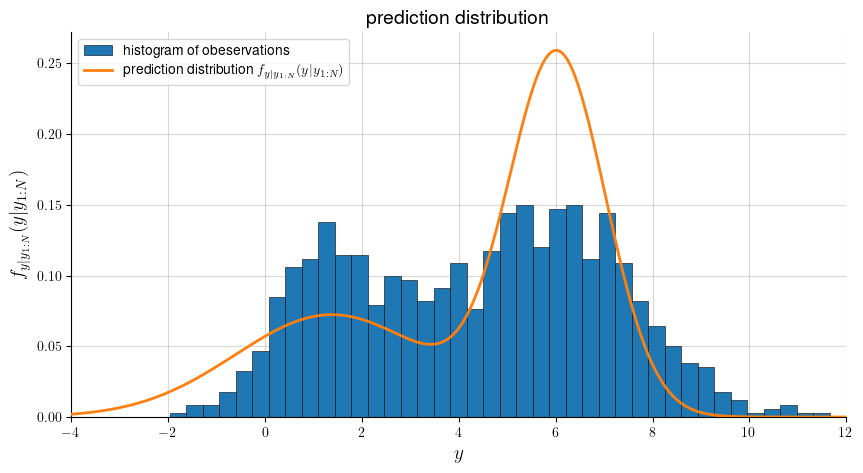

In [134]:
#figure 4 (prediction distribution)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
plt.rcParams['figure.figsize']=10,5
fig = plt.figure()

ax = fig.add_subplot(111)

ax.hist(y, bins=40, density=True, edgecolor="black", linewidth=0.4, zorder=2, label="histogram of obeservations")
ax.plot(range_x, fy, linewidth=2, zorder=3, label="prediction distribution $f_{{y}|{y}_{1:N}}(y|y_{1:N})$")
ax.set_xlabel("$y$", fontsize=14)
ax.set_ylabel("$f_{{y}|{y}_{1:N}}(y|y_{1:N})$", fontsize=14)
ax.set_title("prediction distribution", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim([-4, 12])
plt.legend()

plt.show()

In [26]:
j1 = 0
j2 = 0
NT = 200
y_test = np.zeros(NT)
y1_test = np.zeros(NT)
y2_test = np.zeros(NT)
model_test = np.zeros(N)
prob_estimated_test = np.zeros(NT)
model_estimated_test = np.zeros(NT)

# generating test data
for n in range(NT):
    x = np.random.rand()
    if x <= p: # model 1
        mu = mu1
        y1_test[j1] = np.sqrt(sigma_y1)*np.random.randn() + mu
        y_test[n] = y1_test[j1]
        model_test[n] = 1
        j1 += 1
    else: # model 2
        mu = mu2
        y2_test[j2] = np.sqrt(sigma_y2)*np.random.randn() + mu
        y_test[n] = y2_test[j2]
        model_test[n] = 2
        j2 += 1

error = 0
for n in range(NT): #computing the likelihood for belonging to model k = 1 for each realization
    value1 = scalar_gaussian(y_test[n], mu_1_vec[-1], sigma_y1)
    value2 = scalar_gaussian(y_test[n], mu_2_vec[-1], sigma_y2)
    prob_estimated_test[n] = (estimate_p*value1)/(estimate_p*value1 + (1-estimate_p)*value2) # probability of belonging to model 1

    if prob_estimated_test[n] >= 0.5:
        model_estimated_test[n] = 1
    else:
        model_estimated_test[n] = 2
    if model_estimated_test[n] != model_test[n]:
        error += 1


print("Original: ")
print(f"p: {p}")
print(f"mu1: {mu1}")
print(f"mu2: {mu2}")
print(f"sigma1: {sigma_1}")
print(f"sigma2: {sigma_2}")

# estimate of p obtained by averaging last estimates across all N observations
print("Original: ")
print(f"p: {p_vec.mean()}")
print(f"mu1: {mu_1_vec[-1]}")
print(f"mu2: {mu_2_vec[-1]}")
print(f"sigma1: {sigma_1_vec[-1]}")
print(f"sigma2: {sigma_2_vec[-1]}")

print("Error in assigning correct model: ", (error/NT)*100)

# Remember that the mean estimated for model 1 can correspond to model 2 and vice-versa. 

Original: 
p: 0.3
mu1: -0.2874449925652325
mu2: 11.872884094529823
sigma1: 2
sigma2: 5
Original: 
p: 0.3228027065658518
mu1: -0.31797547499002277
mu2: 11.920103559734219
sigma1: 0.003262615593518556
sigma2: 0.005757073520660943
Error in assigning correct model:  0.0


In [40]:
N = 400 # number of training sample points
NT = 50 # test samples

M = 2 # dimension of w
sigma_w2 = 2 # variance of w
w = np.sqrt(sigma_w2)*np.random.randn(M) # generate a random model w
w_model = w

H = np.random.randn(M, N) # generate feature vectors
gamma_vec = np.zeros(N)

Htest = np.random.randn(M, NT)
gammatest = np.zeros(NT)

n1 = 0 # number of +1 samples
n2 = 0 # number of -1 samples

A1 = np.zeros((N, M))
A2 = np.zeros((N, M))
G1 = np.zeros(N)
G2 = np.zeros(N)

for n in range(N): # training samples
    h = H[:, n]
    x = norm.cdf(h.T@w)
    u = np.random.rand()
    if x >= u:
        gamma_vec[n] = +1
        A1[n1, :] = h.T 
        G1[n1] = gamma_vec[n]
        n1 += 1
    else:
        gamma_vec[n] = -1
        A2[n2, :] = h.T
        G2[n2] = gamma_vec[n]
        n2 += 1

A1 = A1[:n1]
A2 = A2[:n2]
G1 = G1[:n1]
G2 = G2[:n2]

n1 = 0 # number of +1 samples
n2 = 0 # number of -1 samples

A1_test = np.zeros((NT, M))
A2_test = np.zeros((NT, M))
G1_test = np.zeros(NT)
G2_test = np.zeros(NT)

for n in range(NT): # test samples
    h = Htest[:, n]
    x = norm.cdf(h.T@w)
    u = np.random.rand()
    if x >= u:
        gammatest[n] = +1
        A1_test[n1, :] = h.T 
        G1_test[n1] = gamma_vec[n]
        n1 += 1
    else:
        gammatest[n] = -1
        A2_test[n2, :] = h.T
        G2_test[n2] = gamma_vec[n]
        n2 += 1

A1tA1_testest = A1_test[:n1]
A2_test = A2_test[:n2]
G1_test = G1_test[:n1]
G2_test = G2_test[:n2]  

X = (1/sigma_w2)*np.eye(M)
for n in range(N):
    h = H[:, n]
    X += h.reshape(1, -1).T@h.reshape(1, -1)

Rw = np.linalg.inv(X)

beta_ = np.random.randn(N)
alpha = np.random.randn(N)
L = 5 # number of iterations to use
for m in range(L):
    ss = H@beta_
    w = Rw@ss
    for n in range(N):
        h = H[:, n]
        alpha[n] = h.T@w
        x = norm.pdf(alpha[n])
        y = norm.cdf(alpha[n])
        beta_[n] = alpha[n] + gamma_vec[n]*x/y

wbar = w

n1 = 0
n2 = 0
A1_after_testing = np.zeros(A1.shape)
A2_after_testing = np.zeros(A2.shape)
G1_after_testing = np.zeros(G1.shape)
G2_after_testing = np.zeros(G2.shape)

for n in range(NT): # testing
    h = Htest[:, n]
    a = h.T@wbar
    b = 1 + h.T@Rw@h
    b = np.sqrt(b)
    d = norm.cdf(a/b)
    if d >= 1/2:
        A1_after_testing[n1, :] = h.T
        G1_after_testing[n1] = 1
        n1 += 1
    else:
        A2_after_testing[n2, :] = h.T
        G2_after_testing[n2] = 1
        n2 += 1

A1_after_testing = A1_after_testing[:n1]
A2_after_testing = A2_after_testing[:n2]
G1_after_testing = G1_after_testing[:n1]
G2_after_testing = G2_after_testing[:n2]  

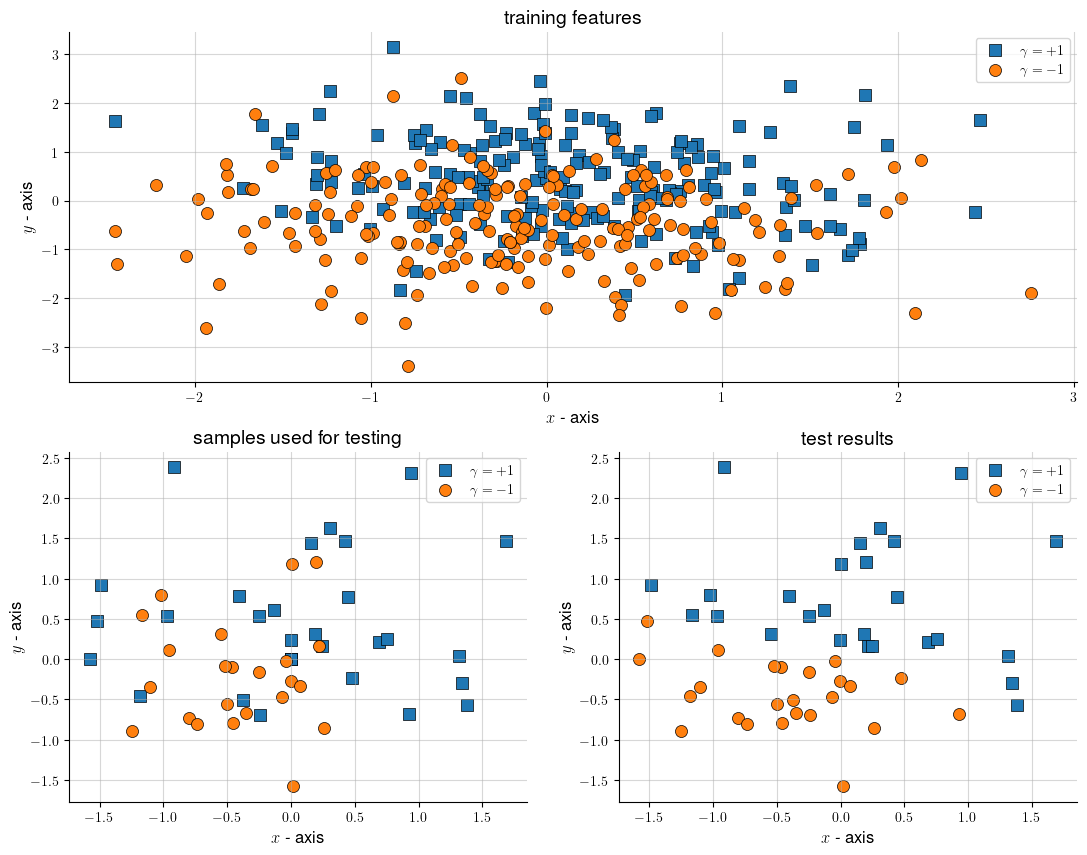

In [41]:
#figure 3 (scatter diagrams)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,10
fig = plt.figure()

ax = fig.add_subplot(2, 2, (1, 2))

ax.scatter(A1[:, 0], A1[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2[:, 0], A2[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("training features", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()


ax = fig.add_subplot(2, 2, 3)

ax.scatter(A1_test[:, 0], A1_test[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2_test[:, 0], A2_test[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("samples used for testing", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

ax = fig.add_subplot(2, 2, 4)

ax.scatter(A1_after_testing[:, 0], A1_after_testing[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2_after_testing[:, 0], A2_after_testing[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("test results", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

plt.show()

In [2]:
B = 7 # number of blocks
L = 1000 # number of legislative issues
N = 100 # number of senators

alpha = 10*np.random.rand(B) # Dirichlet parameters chosen randomly
lambda_1 = 0.1
lambda_2 = 0.1

pi_vec = np.zeros(B)
Theta = np.zeros((B, L))
Theta_hat = np.zeros((B, L))
V = np.zeros((N, L))
b_vec = np.zeros(N)

pi_vec = dirichlet(alpha) # Dirichlet
for b in range(B):
    for ell in range(L):
        Theta[b, ell] = beta(lambda_1, lambda_2)

cum_pi = np.zeros(B) # cummulative density of pi
for b in range(B):
    cum_pi[b] = sum(pi_vec[:b+1])

idx = 0
for n in range(N):
    x = np.random.rand()
    for b in range(B):
        if x > cum_pi[b]: #categorical distribution
            idx += 1
    b_vec[n] = idx

    for ell in range(L):
        y = np.random.rand()
        if y <= Theta[int(b_vec[n]), ell]:
            V[n, ell] = 1
        else:
            V[n, ell] = 0
    idx = 0

lambda_1_hat = np.random.rand(B, L)
lambda_2_hat = np.random.rand(B, L)
alpha_hat = 10*np.random.rand(B)
pi_matrix_hat = np.zeros((N, B))

M = 50 # repeat for this many iterations

for m in range(M):
    a1 = np.zeros(B)
    A2 = np.zeros((N, L))
    for b in range(B):
        a1[b] = digamma(alpha_hat[b]) - digamma(np.ones(B)@alpha_hat) # psi is the digamma function
        for ell in range(L):
            A2[b, ell] = digamma(lambda_1_hat[b, ell]) - digamma(lambda_2_hat[b, ell])
    
    AUX = np.zeros((N, B)) # same size as the pi matrix
    for n in range(N): # this normalization step is added t oavoid overflow / underflow
        for b in range(B):
            x = A2[b, :].T
            y = V[n, :].T
            AUX[n, b] = a1[b] + x.T@y # these values are the ln(pi)

    for n in range(N):
        AUX[n, :] = AUX[n, :] - AUX[n, :].max() # largest entry of each row in AUX will be zero
                                                # using these adjusted entries to compute the 
                                                # pi does not affect the calculation
    
    for n in range(N):
        for b in range(B):
            pi_matrix_hat[n, b] = np.exp(AUX[n, b])

    for n in range(N):
        x = pi_matrix_hat[n, :]
        x = x / x.sum()
        pi_matrix_hat[n, :] = x 
    
    for b in range(B):
        for ell in range(L):
            x = pi_matrix_hat[:, b]
            y = V[:, ell]
            lambda_1_hat[b, ell] = lambda_1 + x.T@y
            lambda_2_hat[b, ell] = lambda_2 + x.sum() - x.T@y
        
    for b in range(B):
        x = pi_matrix_hat[:, b]
        alpha_hat[b] = alpha[b] + x.sum()


for b in range(B): # estimating the theta_{b, ell}
    for ell in range(L):
        Theta_hat[b, ell] = mode_beta(lambda_1_hat[b, ell], lambda_2_hat[b, ell])

estimated_lambda_1 = lambda_1_hat.mean() # averaging all values
estimated_lambda_2 = lambda_2_hat.mean() # averaging all values

estimated_pi_vec = pi_matrix_hat.mean(axis=0)

estimated_b_vec = np.zeros(N)
sum_vec = np.zeros((N, B))

for n in range(N): # for each senator
    for b in range(B): # for each block
        if estimated_pi_vec[b] == 0:
            sumL = -1E10 # a large negative number
        else:
            sumL = np.log(estimated_pi_vec[b])
        for ell in range(L):
            ax = Theta_hat[b, ell]
            bx = V[n, ell]
            if ax != 0 and ax != 1:
                sumL += bx*np.log(ax)+(1-bx)*np.log(1-ax)
            elif ax == 0:
                sumL += -bx*1E10
            elif ax == 1:
                sumL += -(1-bx)*1E10
        sum_vec[n, b] = sumL
    sum_vec[n, :] = sum_vec[n, :]/sum_vec[n, :].sum() # normalization

for n in range(N):
    idd = np.argmax(sum_vec[n, :])
    estimated_b_vec[n] = idd

sorted_b = np.sort(estimated_b_vec)
indexes = np.squeeze(np.concatenate([np.argwhere(estimated_b_vec == j) for j in range(B)]))
number_in_each_block = np.zeros(B)

for n in range(N):
    for b in range(B):
        if sorted_b[n] == b:
            number_in_each_block[b] += 1

groups = 255*np.ones((N, N)) # block assigment
lower = 0
d = np.zeros(B)
for b in range(B):
    d[b] = number_in_each_block[b]
    upper = int(lower+d[b]-1)
    groups[lower:upper+1, lower:upper+1] = 30*b # should be b, but multiplied by 30 to change color of blocks in plot
    lower = int(upper + 1)

unordered_groups = 255*np.ones((B, N))
for n in range(N):
    block = int(estimated_b_vec[n])
    unordered_groups[block, n] = 30*estimated_b_vec[n] # multiplied by 30 to change the color of blocks in plot

print("Lambda 1", lambda_1)
print("Lambda 2", lambda_2)
print("Estimated Lambda 1", estimated_lambda_1)
print("Estimated Lambda 2", estimated_lambda_2)

print("Alpha", alpha)
print("Estimated alpha", alpha_hat)

print("Pi", pi_vec)
print("Estimated Pi", estimated_pi_vec)


    

Lambda 1 0.1
Lambda 2 0.1
Estimated Lambda 1 7.237571428571427
Estimated Lambda 2 7.248142857142856
Alpha [7.19542444 0.48329279 5.84812512 2.69205879 5.09364915 6.50465811
 7.65513305]
Estimated alpha [ 7.19542444 30.48329279  5.84812512  2.69205879  5.09364915 27.50465811
 56.65513305]
Pi [0.15296289 0.00196236 0.12539531 0.05871986 0.19019734 0.16049047
 0.31027177]
Estimated Pi [0.   0.3  0.   0.   0.   0.21 0.49]


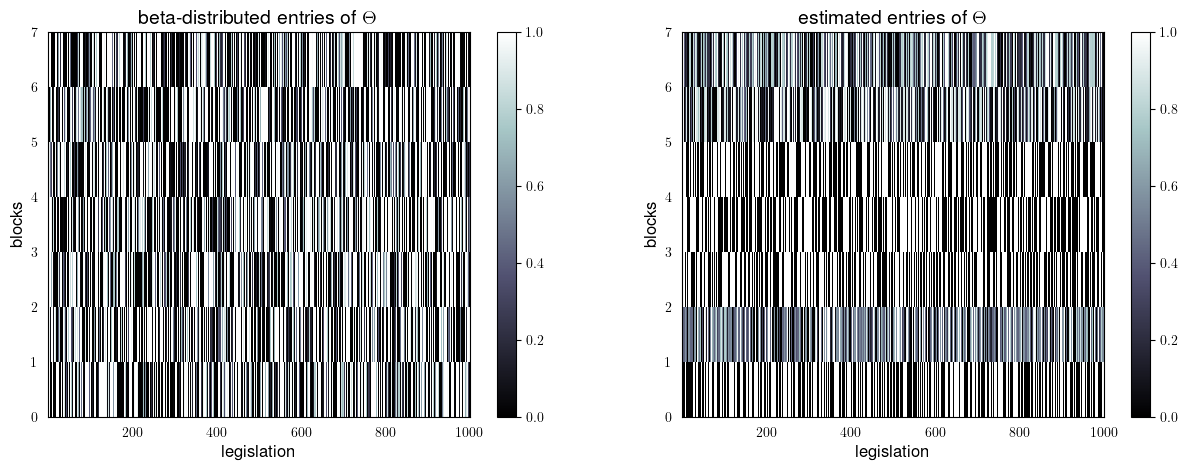

In [20]:
# figure 6 (gray-coded representation)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=15, 5
fig = plt.figure()

ax = fig.add_subplot(121)

heatmap = ax.pcolor(Theta, cmap="bone")
ax.set_xticks(np.arange(200, 1200, 200))
plt.tick_params(left = False)
plt.tick_params(bottom = False)
ax.set_xlabel("legislation", fontsize=12)
ax.set_ylabel("blocks", fontsize=12)
ax.set_title("beta-distributed entries of $\Theta$", fontsize=14)

plt.colorbar(heatmap)


ax = fig.add_subplot(122)

heatmap = ax.pcolor(Theta_hat, cmap="bone")
ax.set_xticks(np.arange(200, 1200, 200))
plt.tick_params(left = False)
plt.tick_params(bottom = False)
ax.set_xlabel("legislation", fontsize=12)
ax.set_ylabel("blocks", fontsize=12)
ax.set_title("estimated entries of $\Theta$", fontsize=14)

plt.colorbar(heatmap)

plt.show()

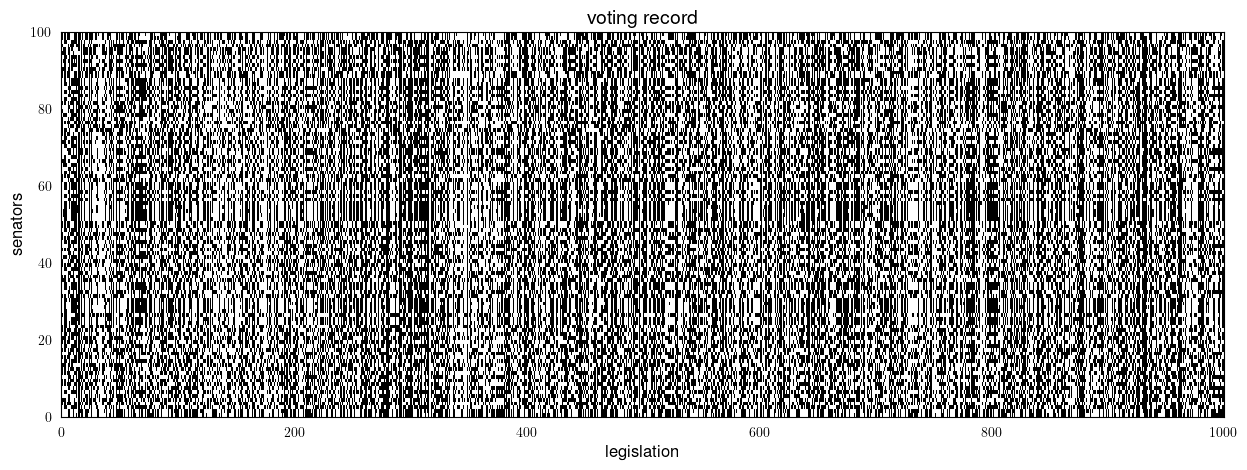

In [4]:
#figure 7 (voting record)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=15, 5
fig = plt.figure()

ax = fig.add_subplot(111)

heatmap = ax.pcolor(V, cmap="bone")
plt.tick_params(left = False)
plt.tick_params(bottom = False)
ax.set_xlabel("legislation", fontsize=12)
ax.set_ylabel("senators", fontsize=12)
ax.set_title("voting record", fontsize=14)

plt.show()

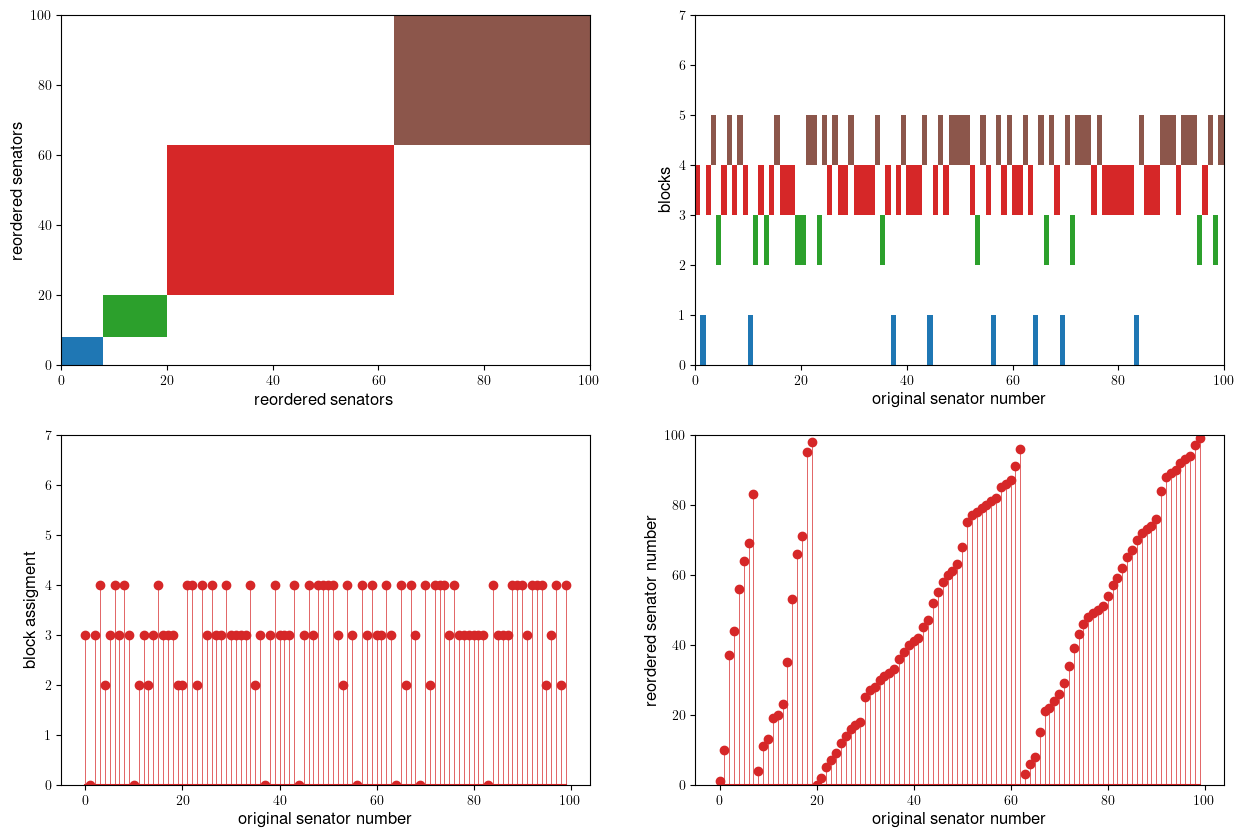

In [21]:
#figure 8  (reordered senators)

# figure 6 (gray-coded representation)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=15, 10
fig = plt.figure()

ax = fig.add_subplot(221)

cMap = c.ListedColormap(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "w"])

ax.pcolor(groups, cmap=cMap)
ax.set_xlabel("reordered senators", fontsize=12)
ax.set_ylabel("reordered senators", fontsize=12)

ax = fig.add_subplot(222)

ax.pcolor(unordered_groups, cmap=cMap)
ax.set_xlabel("original senator number", fontsize=12)
ax.set_ylabel("blocks", fontsize=12)

ax = fig.add_subplot(223)

markerline, stemlines, baseline = ax.stem(np.arange(N), estimated_b_vec)
plt.setp(stemlines, 'color', 'tab:red')
plt.setp(stemlines, 'linewidth', 0.5)
plt.setp(markerline, 'color', 'tab:red')
ax.set_xlabel("original senator number", fontsize=12)
ax.set_ylabel("block assigment", fontsize=12)
ax.set_ylim([0, 7])

ax = fig.add_subplot(224)

markerline, stemlines, baseline = ax.stem(np.arange(N), indexes)
plt.setp(stemlines, 'color', 'tab:red')
plt.setp(stemlines, 'linewidth', 0.5)
plt.setp(markerline, 'color', 'tab:red')
ax.set_xlabel("original senator number", fontsize=12)
ax.set_ylabel("reordered senator number", fontsize=12)
ax.set_ylim([0, N])

plt.show()

In [46]:
w = w_model
epsilon = 0.000001

B = 10 # batch size
w_bar_svi = np.random.randn(M) # initial conditions
sigma_w_svi = np.random.rand() + epsilon
z_bar_svi = np.random.randn(N)
sigma_z_svi = np.random.rand(N) + epsilon
L = 1000 # reapeat for this many iterations

for m in tqdm(range(L)):
  W = np.zeros((M,B))
  Z = np.zeros((N,B))
  for b in range(B): # generate B random samples
      W[:,b] = np.sqrt(sigma_w_svi)*np.random.randn(M)
      W[:, b] = W[:,b] + w_bar_svi

  for n in range(N): # for each n, generate B random samples
    for b in range(B):
      Z[n, b] = np.sqrt(sigma_z_svi[n])*np.random.randn()
      Z[n, b] = Z[n, b] + z_bar_svi[n]
  
  sum_batch = 0
  
  for b in range(B):
    wb = W[:, b]
    zb = Z[:, b]
    lnq = 0
    lnq = lnq - 0.5*np.log(2*np.pi*sigma_w_svi)
    lnq = lnq - (0.5/sigma_w_svi)*(np.linalg.norm(wb-w_bar_svi)**2)
   
    for n in range(N):
      lnq = lnq - 0.5*np.log(2*np.pi*sigma_z_svi[n]) - (0.5/sigma_z_svi[n])*((zb[n]-z_bar_svi[n])**2)
    
    gradq = (1/sigma_w_svi)*(wb-w_bar_svi)
    gradq = np.append(gradq, -((0.5/sigma_w_svi))+(0.5/(sigma_w_svi**2))*(np.linalg.norm(wb-w_bar_svi)**2))  
    
    for n in range(N):
       gradq = np.append(gradq, (1/sigma_z_svi[n])*(zb[n]-z_bar_svi[n]))
       gradq = np.append(gradq, (0.5/(sigma_z_svi[n]**2))*(zb[n]-z_bar_svi[n]**2))
            
    lnf = 0
    lnf = lnf - 0.5*np.log(2*np.pi*sigma_w_svi)
    lnf = lnf - (0.5/sigma_w_svi)*(np.linalg.norm(wb)**2)
  
    for n in range(N):
       lnf = lnf - 0.5*np.log(2*np.pi*sigma_z_svi[n])
       h = H[:,n]
       lnf = lnf -0.5*((zb[n] - h.T@wb)**2)
       if zb[n] > 0:
          lnf = lnf + np.log(0.5*(1+gamma_vec[n])+epsilon) # added epsilon to avoid log0
       else:
          lnf = lnf + np.log(0.5*(1-gamma_vec[n])+epsilon)
    sum_batch = sum_batch + gradq*(lnf - lnq)

  delta = sum_batch/B
  step_size_1 = 0.00000001/(m+1); #step-size for means set to a constant value
  step_size_2 = 0.00000001/(m+1); #step-size for variances
  
  w_bar_svi   = w_bar_svi   + step_size_1*delta[:M]
  sigma_w_svi = sigma_w_svi + step_size_2*delta[M]
  if sigma_w_svi < 0:
      sigma_w_svi = epsilon # to avoid working with negative variances (type of projection)
  
  delta2 = delta[M+1:2*N +M+1]
  for n in range(N):
    z_bar_svi[n]   = z_bar_svi[n]   + step_size_1*delta2[2*n-1]
    sigma_z_svi[n] = sigma_z_svi[n] + step_size_2*delta2[2*n]
    if sigma_z_svi[n] <0:
        sigma_z_svi[n] = epsilon


n1 = 0
n2 = 0
error_test = 0

A1_after_testing = np.zeros(A1.shape)
A2_after_testing = np.zeros(A2.shape)
G1_after_testing = np.zeros(G1.shape)
G2_after_testing = np.zeros(G2.shape)

for n in range(NT): # testing
    h = Htest[:, n]
    a = h.T@wbar
    b = 1 + h.T@Rw@h
    b = np.sqrt(b)
    d = norm.cdf(a/b)
    if d >= 1/2:
        A1_after_testing[n1, :] = h.T
        G1_after_testing[n1] = 1
        n1 += 1
        if gammatest[n] != 1:
           error_test += 1
    else:
        A2_after_testing[n2, :] = h.T
        G2_after_testing[n2] = 1
        n2 += 1
        if gammatest[n] != -1:
           error_test += 1

A1_after_testing = A1_after_testing[:n1]
A2_after_testing = A2_after_testing[:n2]
G1_after_testing = G1_after_testing[:n1]
G2_after_testing = G2_after_testing[:n2]  

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:06<00:00, 14.99it/s]


Mean o w from coordinate ascent and from stochastic variational inference:
[0.79127696 1.80621334] [ 2.36326621 -0.67134861]
Tr(Rw) from coordinate ascent and sigma_w^2 from stochastic variational inference:
0.005309315691185528 0.9322331950855509
Error rate:  26.0


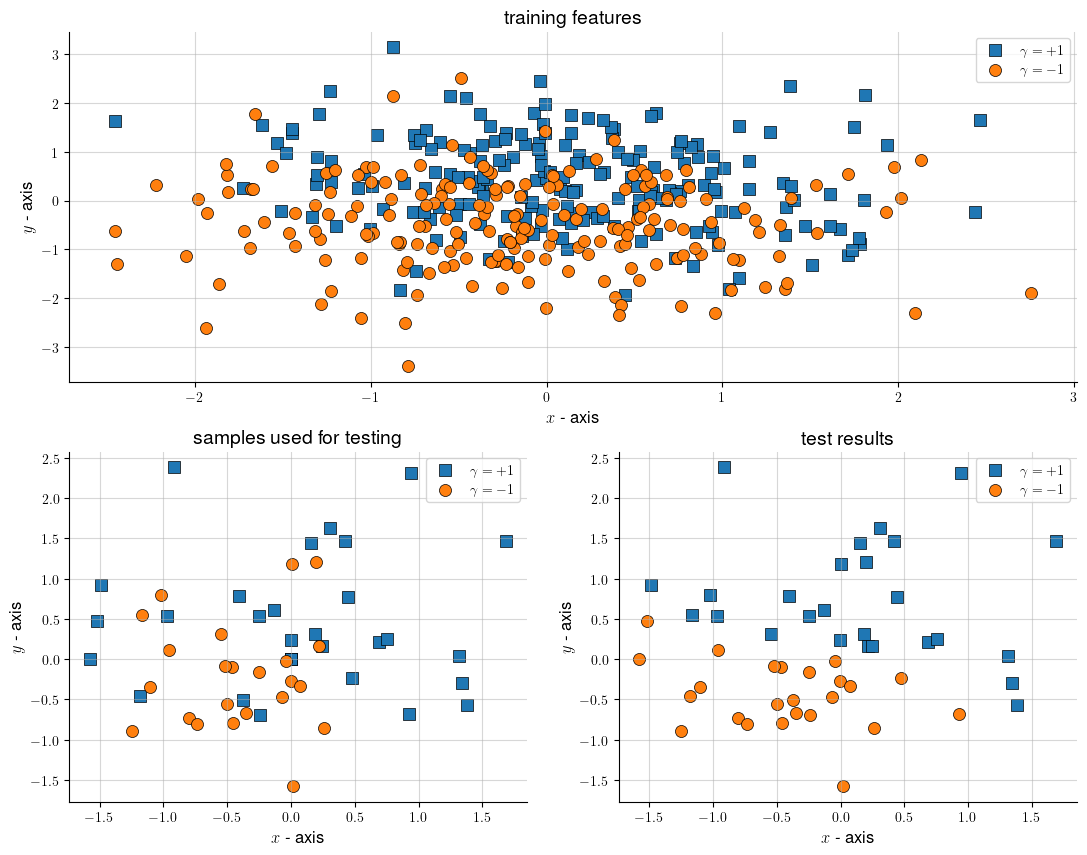

In [49]:
print("Mean o w from coordinate ascent and from stochastic variational inference:")
print(wbar, w_bar_svi)
print("Tr(Rw) from coordinate ascent and sigma_w^2 from stochastic variational inference:")
print(np.trace(Rw), sigma_w_svi)

print("Error rate: ", (error_test/NT)*100)

# figure 9 (scatter diagrams)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,10
fig = plt.figure()

ax = fig.add_subplot(2, 2, (1, 2))

ax.scatter(A1[:, 0], A1[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2[:, 0], A2[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("training features", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()


ax = fig.add_subplot(2, 2, 3)

ax.scatter(A1_test[:, 0], A1_test[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2_test[:, 0], A2_test[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("samples used for testing", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

ax = fig.add_subplot(2, 2, 4)

ax.scatter(A1_after_testing[:, 0], A1_after_testing[:, 1], marker="s", s=75, edgecolors="black", linewidths=0.5, label="$\gamma = +1$")
ax.scatter(A2_after_testing[:, 0], A2_after_testing[:, 1], s=75, edgecolors="black", linewidths=0.5, label="$\gamma = -1$")
ax.set_xlabel("$x$ - axis", fontsize=12)
ax.set_ylabel("$y$ - axis", fontsize=12)
ax.set_title("test results", fontsize=14)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

plt.savefig("figs/fig-5.pdf", format="pdf", bbox_inches="tight")

plt.show()